In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import PIL
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader


In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(f"Using Pytorch v{torch.__version__}, Device: {DEVICE}")

Using Pytorch v2.0.0, Device: cuda


In [4]:
cifar = datasets.CIFAR10(root="./CIFAR_10", train=True, download=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 42965285.42it/s]


Extracting ./CIFAR_10/cifar-10-python.tar.gz to ./CIFAR_10


In [5]:
print(cifar[0])

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7E3F8BFEB7C0>, 6)


## Visualize the 5th element of the cifar10 train dataset with its label.
- hint 1: Use plt.imshow() func to visualize the image.
- hint 2: Use CIFAR10_LABEL to extract the label. With the given label index in the dataset, you can extract the label.

In [6]:
CIFAR10_LABEL = ['airplane','automobile','bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

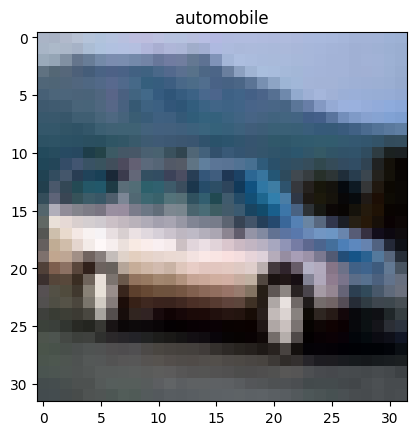

In [7]:
plt.imshow(cifar[4][0])
plt.title(CIFAR10_LABEL[cifar.targets[4]])


def plot_image(image: PIL.Image.Image, label: str):
    
    plt.title(label)
    plt.axis('off')

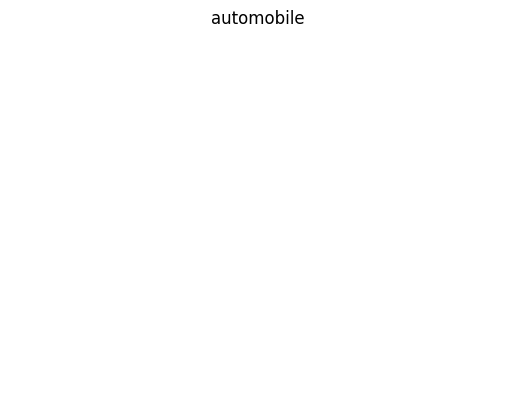

In [8]:
for i in range(5):
    plot_image(cifar[i][0], CIFAR10_LABEL[cifar.targets[i]])

## Custom Dataset

In [9]:
'''
CIFAR10 데이터셋 커스터 마이징
'''
class CustomDataset(Dataset):
    def __init__(self, train, data_dir='./CIFAR_10_Custom'):
        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]


In [10]:
train_dataset = CustomDataset(train=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 31037130.08it/s]


Extracting ./CIFAR_10_Custom/cifar-10-python.tar.gz to ./CIFAR_10_Custom


In [11]:
test_dataset = CustomDataset(train=False)

Files already downloaded and verified


<Image no.0>
torch.Size([3, 32, 32])
frog
<Image no.1>
torch.Size([3, 32, 32])
truck
<Image no.2>
torch.Size([3, 32, 32])
truck
<Image no.3>
torch.Size([3, 32, 32])
deer


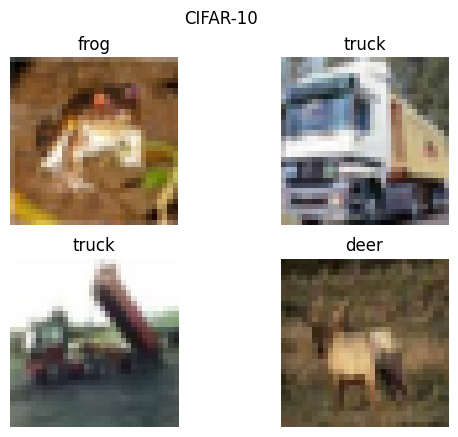

In [12]:
fig = plt.figure()
plt.suptitle('CIFAR-10')
for i in range(4):
    print(f"<Image no.{i}>")
    
    image, label_idx = train_dataset[i]
    label = CIFAR10_LABEL[label_idx]
    
    plt.subplot(2,2,i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    
    toTensor = transforms.ToTensor()
    image = toTensor(image)
    
    
    print(image.shape)
    
    print(label)

## Collate_fn

In [13]:
def collate_fn(data_samples: list[tuple[PIL.Image.Image, int]])-> tuple:
    batch_x, batch_y = [], []
    toTensor = transforms.ToTensor()
#     images, labels = zip(*data_samples)
#     batch_x = [toTensor(x) for x in images]
#     batch_y = labels
    for i, (img, label) in enumerate(data_samples):
        # img : (H, W, C)
        # toTensor(img) -> (C, H, W)
        batch_x.append(toTensor(img))
        batch_y.append(torch.Tensor([label]))
    batch_x = torch.stack(batch_x).float()
    batch_y = torch.tensor(batch_y).long()
    
    return batch_x, batch_y

In [14]:
batch_size = 8
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn
                         )
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn
                         )

In [15]:
image, label = next(iter(train_loader))

print(image.shape)
print(label.shape)
print(image, label)

torch.Size([8, 3, 32, 32])
torch.Size([8])
tensor([[[[0.2392, 0.1882, 0.1765,  ..., 0.3412, 0.3412, 0.3686],
          [0.2235, 0.1647, 0.1765,  ..., 0.3020, 0.3216, 0.3922],
          [0.2157, 0.2078, 0.1765,  ..., 0.2706, 0.3294, 0.3490],
          ...,
          [0.2431, 0.2314, 0.2275,  ..., 0.4353, 0.2588, 0.1882],
          [0.2549, 0.2510, 0.2471,  ..., 0.5608, 0.4078, 0.1490],
          [0.2667, 0.2706, 0.2706,  ..., 0.3843, 0.3020, 0.2510]],

         [[0.4157, 0.3647, 0.3490,  ..., 0.5098, 0.5020, 0.5294],
          [0.3961, 0.3373, 0.3490,  ..., 0.4784, 0.4863, 0.5373],
          [0.3922, 0.3843, 0.3490,  ..., 0.4784, 0.5373, 0.5412],
          ...,
          [0.4353, 0.4235, 0.4235,  ..., 0.4235, 0.2588, 0.2000],
          [0.4471, 0.4431, 0.4431,  ..., 0.5373, 0.4078, 0.1608],
          [0.4588, 0.4627, 0.4627,  ..., 0.3725, 0.3020, 0.2588]],

         [[0.2706, 0.2196, 0.2039,  ..., 0.3451, 0.3373, 0.3569],
          [0.2588, 0.2000, 0.2118,  ..., 0.3020, 0.3137, 0.3765],

## Transforms (Data Augmentation)

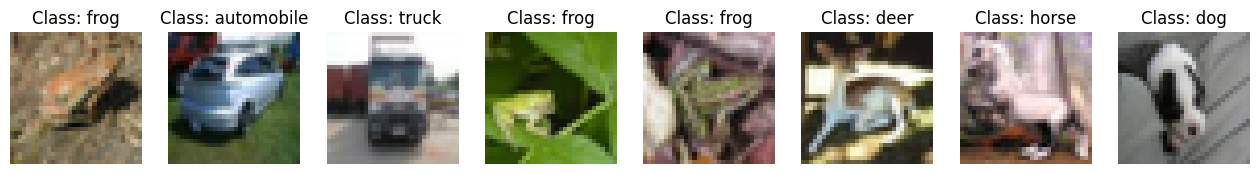

In [16]:
def visualize_batch(batch, augment=None):
    images, labels = batch
    batch_size = images.shape[0]
    pltsize = 2
    plt.figure(figsize=(batch_size * pltsize, pltsize))
    for i in range(batch_size):
        plt.subplot(1, batch_size, i + 1)
        plt.axis('off')
        plt.imshow(np.transpose(augment(images[i]) if augment else images[i], (1, 2, 0)))
        plt.title('Class: ' + str(CIFAR10_LABEL[labels[i].item()]))
    
sample_batch = next(iter(train_loader))
visualize_batch(sample_batch)

## Apply Data augmentation usuing torchvision.transforms module